In [7]:
import numpy as np
from sklearn.semi_supervised import LabelPropagation
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob

# Data Import

In [8]:
pict_dir = "../data/pict_push-ups-from-side/2-1.COCO-pose/"
movi_dir = "../data/movie_push-ups-from-side/2-1.COCO-pose/"

print(glob.glob(pict_dir + "*"))
print(glob.glob(movi_dir + "*"))

['../data/pict_push-ups-from-side/2-1.COCO-pose/0_up.csv', '../data/pict_push-ups-from-side/2-1.COCO-pose/1_down.csv', '../data/pict_push-ups-from-side/2-1.COCO-pose/Z_estimate-error.csv']
['../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_7471.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_7470.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174622.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/VID_20171128_174702.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_4936.csv', '../data/movie_push-ups-from-side/2-1.COCO-pose/IMG_4937.csv']


## データの選定
幡山さんの写ってる動画がよく関節位置が取れていて良さそうだからこれに絞る

In [9]:
pict_up_file = ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # + 
               # ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # 後半は関節認識がうまくいってない
pict_down_file = ["IMG_{}.JPG".format(i) for i in range(4930, 4936)] # + 
               # ["IMG_{}.JPG".format(i) for i in range(4924, 4930)] # 後半は関節認識がうまくいってない
movi_base = "IMG_4937"
movi_file = movi_base + ".csv"

Load

In [10]:
data = np.loadtxt(pict_dir + "0_up.csv", delimiter=",", dtype=str)

m, n = data.shape
for i in range(m):
    for j in range(n):
        data[i, j] = data[i, j][2:-1]
        
up_data = data[:, :-1].astype(float)
img_name = data[:, -1]

filter_img = [img in pict_up_file for img in img_name]
up_data = up_data[filter_img, :]

In [11]:
data = np.loadtxt(pict_dir + "1_down.csv", delimiter=",", dtype=str)

m, n = data.shape
for i in range(m):
    for j in range(n):
        data[i, j] = data[i, j][2:-1]
        
down_data = data[:, :-1].astype(float)
img_name = data[:, -1]

filter_img = [img in pict_down_file for img in img_name]
down_data = down_data[filter_img, :]

In [12]:
movie_data = np.loadtxt(movi_dir + movi_file, delimiter=",", usecols=range(54))

## 特徴量設計（正規化のやり方が古い方）
左右の肩・肘・手の間の距離を使う

|関節名|番号|
|:------|:------|
| 右肩 | 2 |
| 右肘 | 3 |
| 右手 | 4 |
| 左肩 | 5 |
| 左肘 | 6 |
| 左手 | 7 |

~~左右どちらを使うかは、関節はConfidenceの和で決める~~
右に固定

In [24]:
def chooseRL(data):
    '''
    data: data_num x 54
    '''
    right = np.arange(2, 5)
    left = np.arange(5, 8)
    conf_r = np.mean(data[:, right*3 + 2], axis=1)
    conf_l = np.mean(data[:, left*3 + 2], axis=1)
    conf = np.vstack([conf_r, conf_l])
    argmax_conf = np.argmax(conf, axis=0)
    max_conf = np.max(conf, axis=0)
    
    pos_r = np.dstack([data[:, right*3], data[:, right*3+1]]).reshape(-1, 6)
    pos_l = np.dstack([data[:, left*3], data[:, left*3+1]]).reshape(-1, 6)
    pos = np.hstack([pos_r, pos_l])
    print(argmax_conf)
    out = pos[argmax_conf*6:argmax_conf*6+6]
    return out

def extractJointPos(data, index_list):
    return np.dstack([data[:, index_list*3], data[:, index_list*3+1]]).reshape(-1, 2*len(index_list))

def extractJointConf(data, index_list):
    return data[:, index_list*3+2]

def normalizePos(pos, all_data):
    '''
    Assuming...
    pos: n_data x (2*n_selected_joint); x, y, ...
    all_data: n_data x (3*n_all_joint); x, y, conf, ...
    '''
    N, d = pos.shape
    N, D = all_data.shape
    pos = pos.reshape(N, d//2, 2)
    all_data = all_data.reshape(N, D//3, 3)[:, :, 0:2]
    xy_max = np.max(all_data, axis=1)[:, np.newaxis]
    xy_min = np.min(all_data, axis=1)[:, np.newaxis]
    out = (pos - xy_min)/(xy_max - xy_min)
    return out.reshape(N, d)

def deleteLowConf(pos, data):
    '''
    data: data_num x (2*joint_num)
    '''
    N, d = pos.shape
    mask = np.ones(N, dtype=bool)
    mask[np.any(pos == 0., axis=1)] = False
    return pos[mask], data[mask]

def makeFeature(pos):
    n, d = pos.shape
    d //= 2
    _pos = pos.reshape(n, d, 2)
    # カーネル行列を作る時に使うテクニックのテンソル版
    a = np.repeat(np.sum(_pos**2, axis=2)[:, :, np.newaxis], d, axis=2)
    b = np.transpose(a, (0, 2, 1))
    c = np.einsum("ijk,ilk->ijl", _pos, _pos)
    out = a - 2*c + b
    i1, i2 = np.triu_indices(d, k=1)
    out = out[np.repeat(np.arange(n), [d]), np.tile(i1, n), np.tile(i2, n)].reshape(n, d*(d-1)//2)
    return out

In [25]:
# right = np.arange(2, 5)
# up_pos, up_conf = extractJointPos(up_data, right), extractJointConf(up_data, right)
# down_pos, down_conf = extractJointPos(down_data, right), extractJointConf(down_data, right)
# movie_pos, movie_conf = extractJointPos(movie_data, right), extractJointConf(movie_data, right)

In [26]:
right = np.arange(2, 5)
(up_pos, up_data), up_conf = deleteLowConf(extractJointPos(up_data, right), up_data), extractJointConf(up_data, right)
(down_pos, down_data), down_conf = deleteLowConf(extractJointPos(down_data, right), down_data), extractJointConf(down_data, right)
(movie_pos, movie_data), movie_conf = deleteLowConf(extractJointPos(movie_data, right), movie_data), extractJointConf(movie_data, right)

In [27]:
# 位置の正規化
# nm_up_pos = up_pos / np.max(up_data, axis=1)[:, np.newaxis]
# nm_down_pos = down_pos / np.max(down_data, axis=1)[:, np.newaxis]
# nm_movie_pos = movie_pos / np.max(movie_data, axis=1)[:, np.newaxis]

In [28]:
nm_up_pos = normalizePos(up_pos, up_data)
nm_down_pos = normalizePos(down_pos, down_data)
nm_movie_pos = normalizePos(movie_pos, movie_data)

In [29]:
# 肩を原点にして特徴量にする
# nm_up_pos = nm_up_pos[:, 2:] - np.tile(nm_up_pos[:, :2], (1, 2))
# nm_down_pos = nm_down_pos[:, 2:] - np.tile(nm_down_pos[:, :2], (1, 2))
# nm_movie_pos = nm_movie_pos[:, 2:] - np.tile(nm_movie_pos[:, :2], (1, 2))

In [30]:
# 肩・肘・手の距離を並べたものを特徴量にする
nm_up_pos = makeFeature(nm_up_pos)
nm_down_pos = makeFeature(nm_down_pos)
nm_movie_pos = makeFeature(nm_movie_pos)

# 半教師あり学習（訓練データとテストデータが同じ）
全部訓練に使って、テストにも使う  
結果：ダメ

くっつけてラベルも作る

| クラス | ラベル |
|:------|------:|
|up|1|
|down|0|
|unknown|-1|

In [37]:
test_ratio = 0.8
train_max_index = int(nm_movie_pos.shape[0]*(1 - test_ratio))
train_nm_movie_pos = nm_movie_pos
test_nm_movie_pos = nm_movie_pos

train_data = np.vstack([nm_up_pos, nm_down_pos, train_nm_movie_pos])
test_data = test_nm_movie_pos
print(train_data.shape)

(853, 3)


In [38]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int),
    -1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
])
print(labels.shape)

(853,)


In [39]:
clf = LabelPropagation()
clf.fit(train_data, labels)

LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000, n_jobs=1,
         n_neighbors=7, tol=0.001)

In [40]:
pred_label = clf.predict(test_data)

In [41]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

Traceback (most recent call last):
  File "/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 389, in process
    proxy(*args, **kwargs)
  File "/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


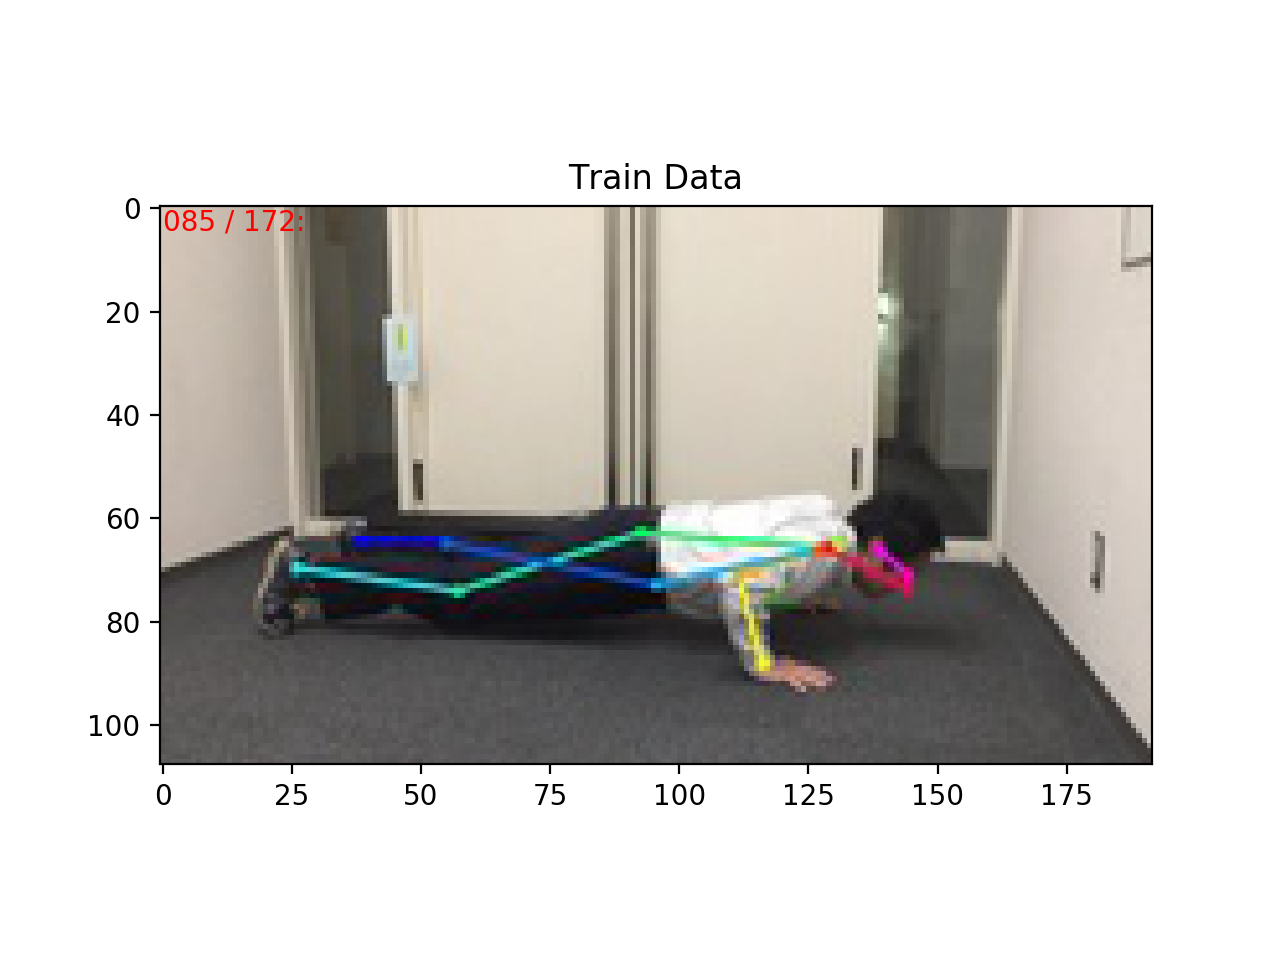

In [17]:

%matplotlib nbagg

fig = plt.figure()
plt.title("Train Data")
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files[:train_max_index]

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = ("%03d / %03d: " % (i, len(test_img_files)))
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

<IPython.core.display.Javascript object>


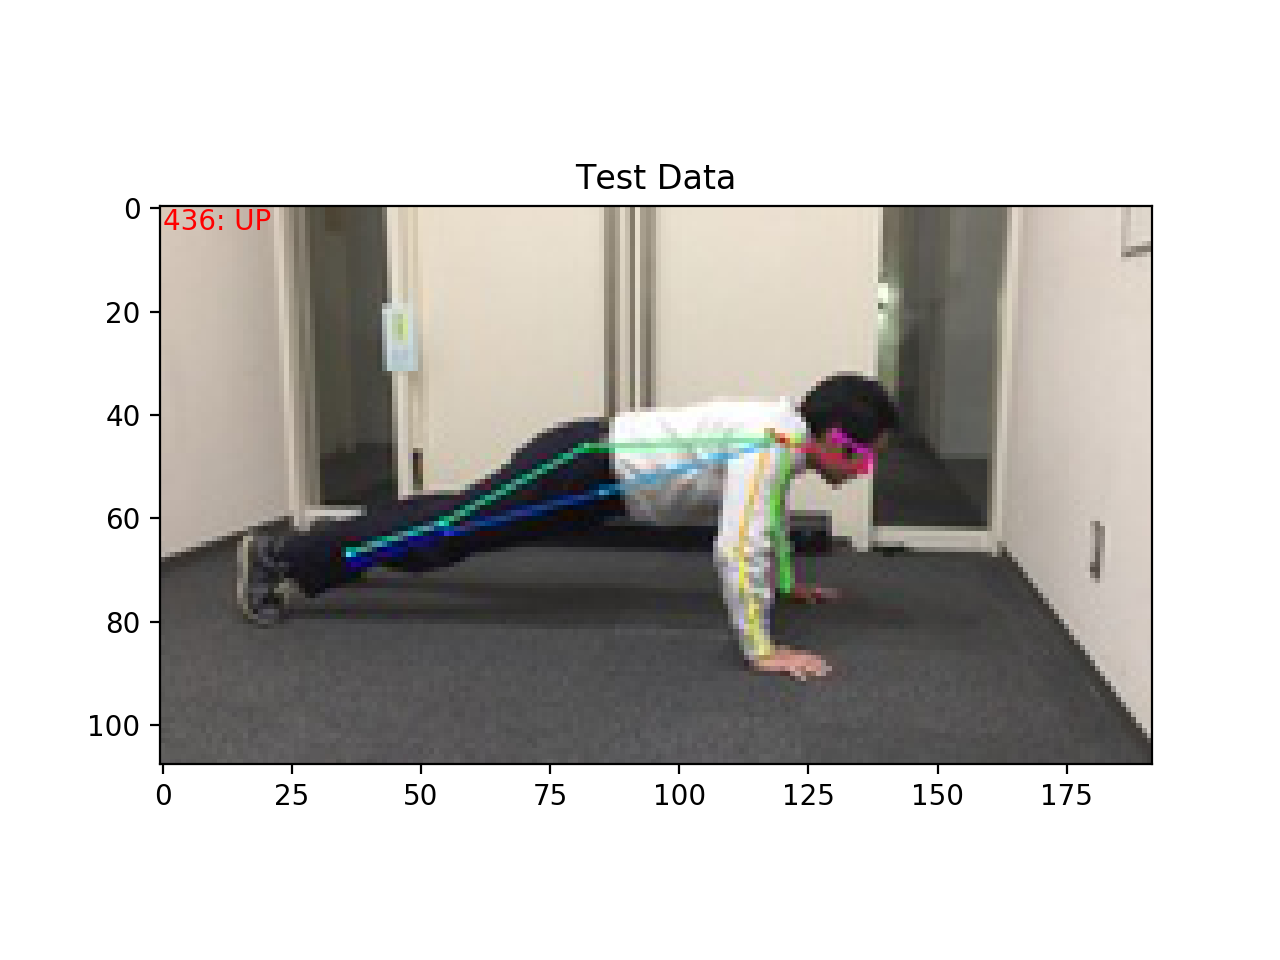

In [18]:
%matplotlib nbagg

fig = plt.figure()
plt.title("Test Data")
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files[train_max_index:]

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = ("%03d: " % i) + ("UP" if pred_label[i] == 1 else "DOWN")
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

---

# 半教師あり学習（ランダムに訓練データを抽出する）
結果：ダメ

| クラス | ラベル |
|:------|------:|
|up|1|
|down|0|
|unknown|-1|

In [16]:
test_ratio = 0.5
train_nm_movie_pos, test_nm_movie_pos, _, _ = train_test_split(nm_movie_pos, np.array([-1]*nm_movie_pos.shape[0]), test_size=test_ratio)

train_data = np.vstack([nm_up_pos, nm_down_pos, train_nm_movie_pos])
test_data = test_nm_movie_pos
print(train_data.shape)

(442, 4)


In [17]:
labels = np.hstack([
    1 * np.ones(nm_up_pos.shape[0], dtype=int),
    0 * np.ones(nm_down_pos.shape[0], dtype=int),
    -1* np.ones(train_nm_movie_pos.shape[0], dtype=int)
])
print(labels.shape)

(442,)


In [18]:
clf = LabelPropagation()
clf.fit(train_data, labels)

LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000, n_jobs=1,
         n_neighbors=7, tol=0.001)

In [19]:
pred_label = clf.predict(test_data)

In [20]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

Traceback (most recent call last):
  File "/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 389, in process
    proxy(*args, **kwargs)
  File "/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/Users/kentaro_abe/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/animation.py", line 1560, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


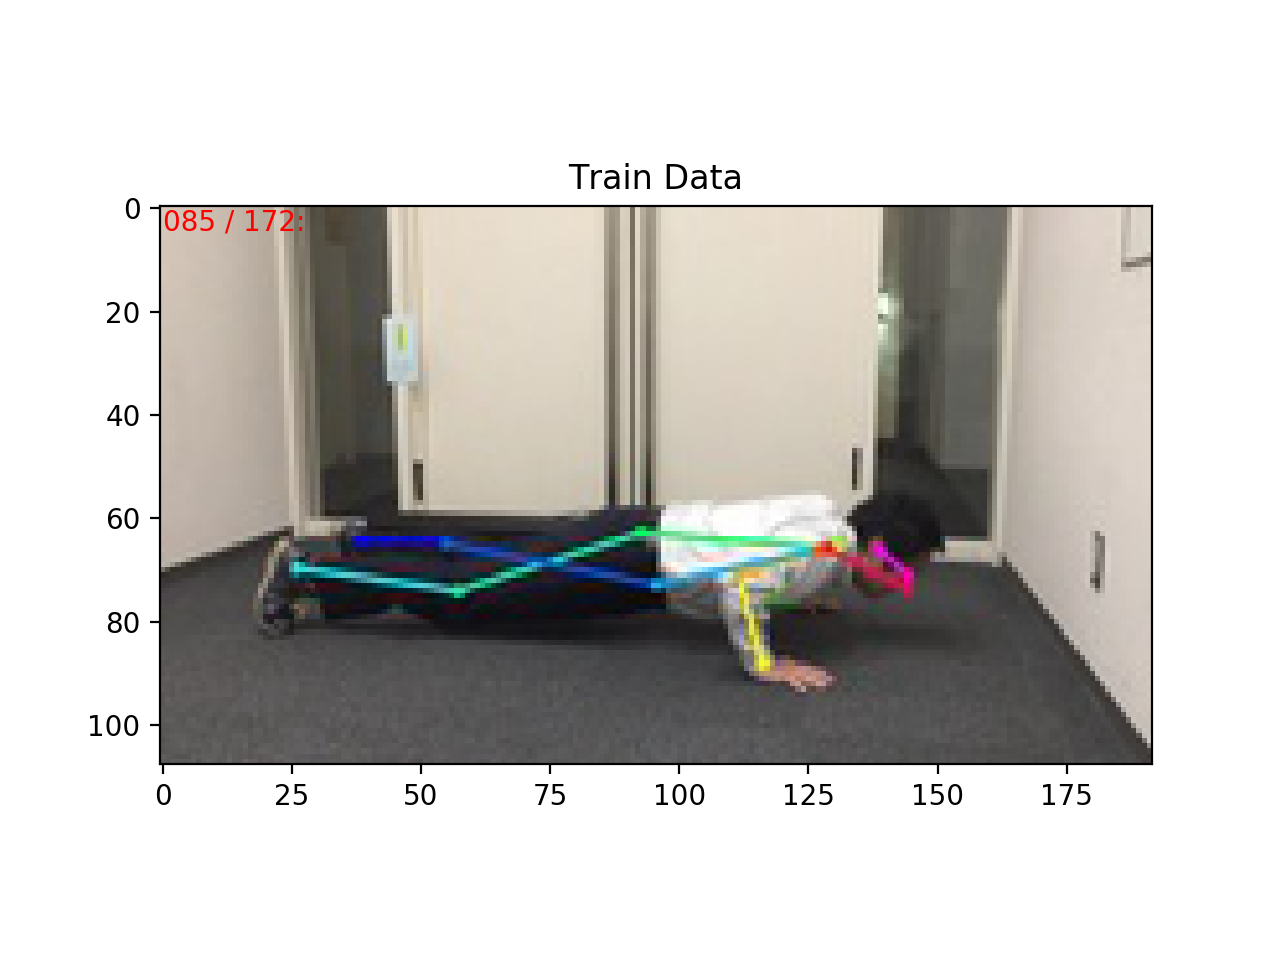

In [17]:

%matplotlib nbagg

fig = plt.figure()
plt.title("Train Data")
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files[:train_max_index]

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = ("%03d / %03d: " % (i, len(test_img_files)))
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()

<IPython.core.display.Javascript object>


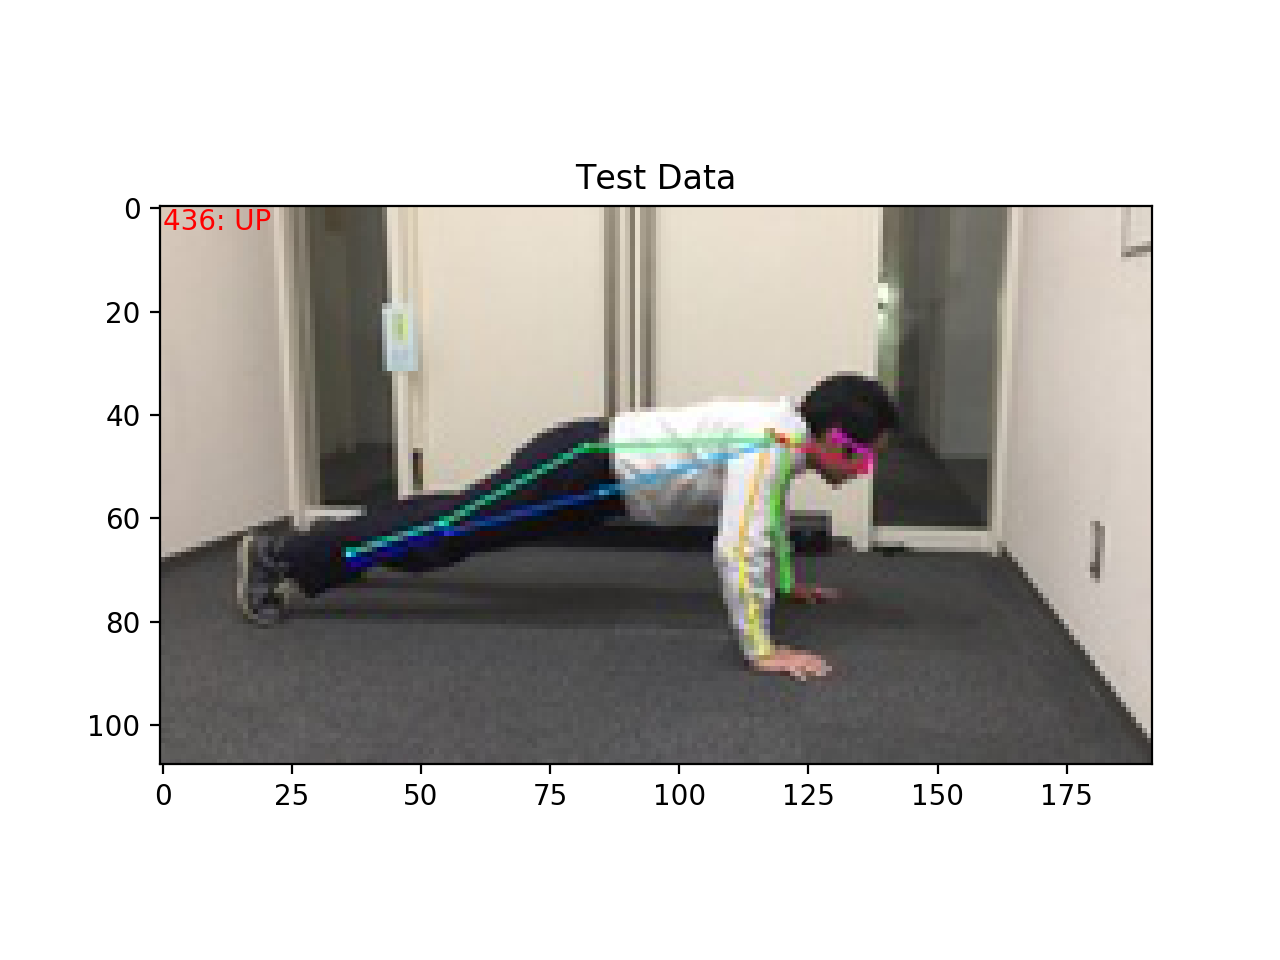

In [18]:
%matplotlib nbagg

fig = plt.figure()
plt.title("Test Data")
imgs_pardir = "../data/movie_push-ups-from-side/2-3.COCO-pict-mini/"
imgs_folder = imgs_pardir + movi_base

img_files = sorted(glob.glob(imgs_folder + "/*.jpg"))
test_img_files = img_files[train_max_index:]

ims = []
for i, img_file in enumerate(test_img_files):
    img = plt.imread(img_file)
    text = ("%03d: " % i) + ("UP" if pred_label[i] == 1 else "DOWN")
    ims.append([plt.imshow(img), plt.text(0, 0, text, ha="left", va="top", color="red")])
    
ani = animation.ArtistAnimation(fig, ims, interval=10, repeat=True)
plt.show()